In [9]:
import numpy as np
import pandas as pd
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.utils import to_categorical
import h5py
import cv2
import os
from matplotlib import pyplot as plt
%matplotlib inlineimport pandas as pd

UsageError: unrecognized arguments: pandas as pd


In [10]:
data_dir = './DataGender'
num_classes = 2

In [11]:
def load_dataset(data_df):
    '''Function to load dataset.'''
    x = []
    y = []
    for i, r in data_df.iterrows():
        f = os.path.join(data_dir, r['file name'])   # filename
        c = r['labels']                              # class

        # Load and resize the image
        img = image.load_img(f, target_size=(150, 150))

        # Convert the Image object into a numpy array
        img = image.img_to_array(img)

        # Add to a list of images and classes
        x.append(img)
        y.append(c)
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y

In [12]:
# Training set
train_df = pd.read_csv(os.path.join(data_dir, 'gender_train.csv'))
raw_train_x, raw_train_y = load_dataset(train_df)

# Test set
test_df = pd.read_csv(os.path.join(data_dir, 'gender_test.csv'))
raw_test_x, raw_test_y = load_dataset(test_df)

In [13]:
# Preprocess the input array
x_train = preprocess_input(raw_train_x)
x_test = preprocess_input(raw_test_x)

# Convert class data to one-hot format
y_train = to_categorical(raw_train_y, num_classes)
y_test = to_categorical(raw_test_y, num_classes)

# Convert the preprocessing images into `float32`
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# Convert the one-hot vector into `int`
y_train = y_train.astype(np.int)
y_test = y_test.astype(np.int)

print('x_train:', x_train.shape)
print('x_test:', x_test.shape)

x_train: (2800, 150, 150, 3)
x_test: (530, 150, 150, 3)


In [19]:
# validation set
x_val = x_train[:280]
y_val = y_train[:280]
x_val.shape

(280, 150, 150, 3)

In [14]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from keras.constraints import maxnorm
from keras.optimizers import SGD , Adam

In [4]:
model = tf.keras.Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(96, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(96, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 96)        5

In [22]:
batch_size = 32
epochs = 10

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
             loss=tf.keras.losses.categorical_crossentropy,
             metrics=['accuracy'])

In [23]:
history = model.fit(x_train, y_train, batch_size=batch_size,
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_data=(x_val, y_val),
                    epochs=epochs)

Train on 2800 samples, validate on 280 samples
Epoch 1/10
2768/2800 [============================>.] - ETA: 2s - loss: 0.3585 - accuracy: 0.8396 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

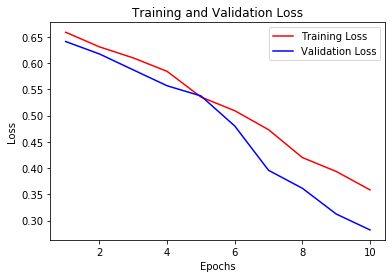

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

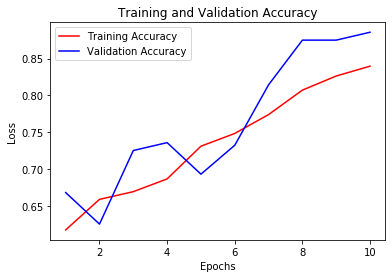

In [26]:
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [27]:
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=32, verbose=0)
print('test acc: ', test_acc)

test acc:  0.65849054


In [28]:
model.save("gender_1.h5")

In [15]:
from sklearn.metrics import confusion_matrix

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [39]:
new_model = tf.keras.models.load_model('gender_1.h5')

In [40]:
y_predict = new_model.predict_classes(x_test, batch_size=32, verbose=0)

In [35]:
y_predict[:1]

array([0])

In [41]:
y_labels = np.argmax(y_test, axis=1)

In [36]:
y_labels[:1]

array([1])

In [42]:
precision = precision_score(y_labels, y_predict)
print('Precision: %f' % precision)

recall = recall_score(y_labels, y_predict)
print('Recall: %f' % recall)

f1 = f1_score(y_labels, y_predict)
print('F1 score: %f' % f1)

Precision: 0.582524
Recall: 0.775862
F1 score: 0.665434


In [43]:
confusion_matrix(y_labels, y_predict)

array([[169, 129],
       [ 52, 180]])